**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest from scratch!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

/home/ubuntu/fastai/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load in our data from last lesson

In [3]:
pwd

'/home/ubuntu/fastai/courses/ml1'

In [4]:
PATH = "/home/ubuntu/fastai/data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

In [7]:
x_sub.head()

,YearMade,MachineHoursCurrentMeter
0,2004,68.0
1,1996,4640.0
2,2001,2838.0
3,2001,3486.0
4,2007,722.0


## Basic data structures

Trying out class enviroment

In [8]:
class house():
    "This is a class containing variables about the house"
    age = 10
    size = 200
    
    def vardisp(self):
        print('age is',self.age,'with size',self.size)
        
        
    

In [9]:
class ComplexNumber():
    def __init__(self,r=0,i=0):
        self.real = r
        self.imag  = i
        
    def get_data(self):
        print(f'{self.real}+{self.imag}i')

In [10]:
num = ComplexNumber(r=1, i=4)

In [11]:
num.get_data()


1+4i


#### Creating the forest

In [12]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs],self.y[idxs], 
                            idxs = np.array(range(self.sample_sz)),min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis = 0)

#### Creating each tree in the forest

Testing

In [13]:
class DecisionTree():
    def __init__(self,x,y,idxs,min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf = x,y,idxs,min_leaf

See how our class is going to be called

In [14]:
m = TreeEnsemble(x=X_train, y=y_train, n_trees=10, sample_sz=100, min_leaf=3)

call object inside TreeEnsemble

In [15]:
m.create_tree().idxs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

## Starting over Create Forrest

Notices that idxs have been changed by jeremy to rnd_idxs. As it is specific for a random subset of our traning data.  

In [16]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

#### Creating each tree

A tree consists of a sequence of binary decisions.

When building a random forest from scratch.

We want to pick a feature and it's threshold to select the best single binary spilt we can make.
The best single binary spilt we can make is determine by the weighted average of the mean squared errors over the new nodes(Ture/False).
Conclusion: We simply try every feature and every threshold of that feature to see which feature and which value that will give us the spilt with the best possiable weighted average of the nodes.

Regrading the tree in script randomforestregression_blue_book_

The first line indicates the binary split criteria
sample at the root is 20,000 since that is what we specified when splitting the data.

value is aveage of the log of price, and if we built a model where we just used the average all the time, then the mean squared error mse would be 0.445
The best single binary split we can make turns out to be Coupler_system ≤ 0.5 which will improve mse to 0.115 in false path and 0.397 in true path
Darker color indicates higher value

We will Create a new class called desicionTree. It will take as input x, y, min_leaf and a array called idxs.

idxs is needed to keep track of which of the row indies that goes into the left-hand-side and the rigth-hand-side as we split our tree into subtrees. We will set Idxs to none in the function and if not given elsewise we will idxs=np.arange(len(y))

In [17]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i) #calls function find_better_split(var_idx)
            
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass  
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
    
    # A property is something that looks like a regular variable but 
    # it’s actually calculated on the fly. What this says is basically 
    # you don’t have to include the parentheses when you call it.
    @property
    def is_leaf(self): return self.score == float('inf')
    
    # To get a representation of this object. A printout of how many rows 
    # are in this node and what’s the average of the dependent variable.
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
    
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s
    
        # when I call is_leaf, it actually calls "def is_leaf(self)"" function above.
        # So it is going to say is this a leaf or not. So a leaf is something 
        # that we don’t split on. If we haven’t split on it, then its score is 
        # still set to infinity, so that’s my logic.
        
        # Why is it leaf if score is infinity?
        # -> the root will have a split assuming we find one. Everything will have a
        # split till we get all the way to the bottom(i.e. the leaf) so the leaves will 
        # have a score of infinity because they won’t split.

In [18]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [19]:
m.trees[0]

n: 1000; val:10.079014121552744

In [20]:
m.trees[0].x

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
153832,1534912,1246843,7043,132,99.0,2001,0.0,0,455,168,...,300,False,False,False,False,False,False,1288137600,False,True
199920,1638573,1461409,4605,132,2.0,2001,0.0,0,493,175,...,90,True,False,True,False,False,False,1112227200,False,True
355950,2432635,1689914,17310,136,2.0,2004,109200.0,1,4207,1528,...,83,False,False,False,False,False,False,1237852800,True,False
147921,1520258,732749,2758,132,5.0,1997,0.0,0,2190,696,...,288,False,False,False,False,False,False,1129334400,False,True
275302,1825370,1174231,10362,132,1.0,1994,0.0,0,4389,1623,...,259,False,False,False,False,False,False,937440000,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80281,1376243,578184,107,132,21.0,1993,0.0,0,2098,681,...,345,False,False,False,False,False,False,944870400,False,True
385678,4319295,2283592,4579,172,1.0,2005,0.0,0,253,93,...,167,False,False,False,False,False,False,1308182400,False,False
283150,1894502,1554766,12594,132,2.0,1000,0.0,0,4918,1913,...,310,False,False,False,False,False,False,878774400,False,True
277559,1839919,1412164,36359,132,99.0,1000,0.0,0,1498,450,...,75,False,False,False,False,False,False,795312000,False,True


## Single branch

### Find best split given variable

So let’s start by making sure we’ve got something to compare to. 

In [21]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [22]:
tree

n: 1000; val:10.079014121552744

So the thing we are going to compare to will be scikit-learn’s random forest. We need to make sure that scikit-learn’s random forest gets exactly the same data that we have, so we start out by creating ensemble, grab a tree out of it, and then find out which particular random sample of x and y did this tree use and we are going to store them away so that we can pass them to scikit-learn (so we have exactly the same information).

So let’s go ahead and now create a random forest using scikit-learn. One tree (n_estimators), one decision (max_depth), no bootstrapping so the whole dataset. 


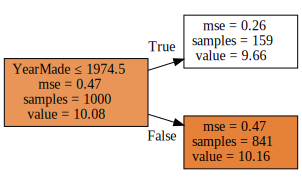

In [23]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

Now we will define find_better_split.


So let’s now go through every single value in our independent variable. And I’ll show you what’s going to happen [35:22]. Let’s say our independent variable is YearMade and it’s not going to be in an order. So we are going to go to the very first row and we are going to say okay, YearMade here is 3. So what I’m going to do is I’m going to try and calculate the score if we decided to branch on the number 3. So I need to know which rows are greater than 3, which rows are less than or equal to 3 and they are going to become my left-hand side and my right hand side. Then we need a score. There’s lots of scores we could use so in random forests, we call this the information gain. The information gain is like how much better does our score get because we split it into these two groups of data. There’s lots of ways we could calculate it: Gini, cross-entropy, root mean squared error, etc. If you think about it, there is an alternative formulation of root mean squared error which is mathematically the same to within a constraint scale but a little bit easier to deal with which is we are going to try and find a split which causes the two groups to each have as lower standard deviation as possible. So I want to find a split that puts all the cats over here and all the dogs over there. So if these are all cats and those are all dogs, then this has a standard deviation of zero and that has a standard deviation of zero. Or else this is a totally random mix of cats and dogs, and that is a totally random mix of cats and dogs, they are going to have a much higher standard deviation. Does that make sense? So it turns out if you find a split that minimizes those group standard deviations or specifically the weighted average of the two standard deviations, it’s mathematically the same as minimizing the root mean squared error.

In [24]:
def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    #self.idxs is an array  
    
    
    #Loops through all rows
    for i in range(self.n):
        # seperating the rows in a rhs and left and side based on the row in question 
        lhs = x<=x[i] # -> array of false every time it’s not less than or equal to; and true otherwise,
        rhs = x>x[i] # -> rhs will be a boolean array of the opposite. 
        
        if rhs.sum()<self.min_leaf or lhs.sum()<self.min_leaf: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum() 
        if curr_score<self.score: # check is this better than our best score so far and store var
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

In [25]:
%timeit find_better_split(tree,1)
tree

73.4 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

let’s compare with scikit-learn’s random forest above, and yes, that was what this tree did as well. 

In [26]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

So tell me what is the computational complexity of this section of the code?

calculate computational complexity: 

The technique is basically “is there a loop?” if so we are obviously doing this n times so there is an n involved. Is there a loop inside the loop? If there is, then you need to multiply those two together. In this case, there is not. Is there anything inside the loop that’s not a constant time operation? So you might see a sort in there and you just need to know that sort is nlog(n) — that should be second nature. If you see a matrix multiply, you need to know what that is. In this case, there are some things that are doing element-wise array operations so keep an eye out for anything where numpy is doing something to every value of an array. In this case is checking every value of x against a constant so it’s going to have to do that n times. So to flesh this out into a computational complexity, you just take the number of things in the loop and you multiply it by the highest computational complexity inside the loop, n times n is n².

In this case, couldn’t we just presort the list and then do one nlog(n) computation [45:10]? There’s lots of things we can do to speed this up, so at this stage is just what is the computational complexity we have. But absolutely. It’s certainly not as good as it can be. So that’s where we’re going to go next. Just like alright, n² is not great so let’s try and make it better.

### Speeding things up 

In [27]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

In [28]:
def std_agg(cnt, s1, s2): return math.sqrt(((s2/cnt) - (s1/cnt))**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf-1 or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

##### Testing the improved loop as given above 

In [29]:
x_sub2 = x_samp[0:8]

In [30]:
y_sub2 = y_samp[0:8]

In [31]:
x_sub2 

,YearMade,MachineHoursCurrentMeter
153832,2001,0.0
199920,2001,0.0
355950,2004,109200.0
147921,1997,0.0
275302,1994,0.0
369472,1986,0.0
339457,1998,0.0
198346,2000,0.0


In [32]:
y_sub2 

array([ 9.15905, 10.5321 ,  8.88876, 10.35774, 10.34174,  9.87817,  9.79813, 10.20359])

In [33]:
x,y = x_sub2.values[:,0], y_sub2[:]

In [34]:
x

array([2001., 2001., 2004., 1997., 1994., 1986., 1998., 2000.])

In [35]:
y

array([ 9.15905, 10.5321 ,  8.88876, 10.35774, 10.34174,  9.87817,  9.79813, 10.20359])

In [36]:
sort_idx = np.argsort(x)

In [37]:
sort_y,sort_x = y[sort_idx], x[sort_idx]

In [38]:
sort_x

array([1986., 1994., 1997., 1998., 2000., 2001., 2001., 2004.])

In [39]:
sort_y

array([ 9.87817, 10.34174, 10.35774,  9.79813, 10.20359,  9.15905, 10.5321 ,  8.88876])

In [40]:
rhs_cnt,rhs_sum,rhs_sum2 = len(sort_y), sort_y.sum(), (sort_y**2).sum()

In [41]:
rhs_cnt,rhs_sum,rhs_sum2

(8, 79.15927427209347, 785.7524881234083)

In [42]:
lhs_cnt,lhs_sum,lhs_sum2,score = 0,0.,0.,100

In [43]:
def std_agg(cnt, s1, s2): return math.sqrt(((s2/cnt) - (s1/cnt))**2)

In [44]:
for i in range(0,7):
        xi,yi = sort_x[i],sort_y[i]
        print("xi = ",xi,"yi = ",yi)
        print("----")
        lhs_cnt += 1; rhs_cnt -= 1
        print("lhs_cnt =", lhs_cnt,"rhs_cnt = ",rhs_cnt)
        print("----")
        lhs_sum += yi; rhs_sum -= yi
        print("lhs_sum =",lhs_sum,"rhs_sum=",rhs_sum)
        print("----")
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
       
        if xi==sort_x[i+1]:
            print("continue")
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        print("current score",curr_score)
        if curr_score<score:
            print("better score")
            var_idx,score,split = i,curr_score,xi
            print("i =",i)

xi =  1986.0 yi =  9.878169744551839
----
lhs_cnt = 1 rhs_cnt =  7
----
lhs_sum = 9.878169744551839 rhs_sum= 69.28110452754163
----
current score 706.5932138513147
xi =  1994.0 yi =  10.341742483467284
----
lhs_cnt = 2 rhs_cnt =  6
----
lhs_sum = 20.219912228019123 rhs_sum= 58.93936204407434
----
current score 706.5932138513148
xi =  1997.0 yi =  10.357742824813725
----
lhs_cnt = 3 rhs_cnt =  5
----
lhs_sum = 30.577655052832846 rhs_sum= 48.58161921926062
----
current score 706.5932138513147
xi =  1998.0 yi =  9.798127036878302
----
lhs_cnt = 4 rhs_cnt =  4
----
lhs_sum = 40.37578208971115 rhs_sum= 38.78349218238232
----
current score 706.5932138513148
xi =  2000.0 yi =  10.203592144986466
----
lhs_cnt = 5 rhs_cnt =  3
----
lhs_sum = 50.57937423469762 rhs_sum= 28.579900037395852
----
current score 706.5932138513147
xi =  2001.0 yi =  9.159047077588632
----
lhs_cnt = 6 rhs_cnt =  2
----
lhs_sum = 59.73842131228625 rhs_sum= 19.42085295980722
----
continue
xi =  2001.0 yi =  10.53209621195

### Speeding things up - - continued. 

In [45]:
def std_agg(cnt, s1, s2): return math.sqrt(((s2/cnt) - (s1/cnt))**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf-1 or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [46]:
%timeit find_better_split(tree,1)
tree

2.74 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 1000; val:10.079014121552744; score:91978.3039160182; split:0.0; var:MachineHoursCurrentMeter

In [47]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:91978.30391601802; split:1985.0; var:YearMade

In [48]:
DecisionTree.find_better_split = find_better_split

In [49]:
tree = TreeEnsemble(x_sub, y_train, n_trees=1, sample_sz=1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:91978.30391601802; split:1985.0; var:YearMade

## Full single tree

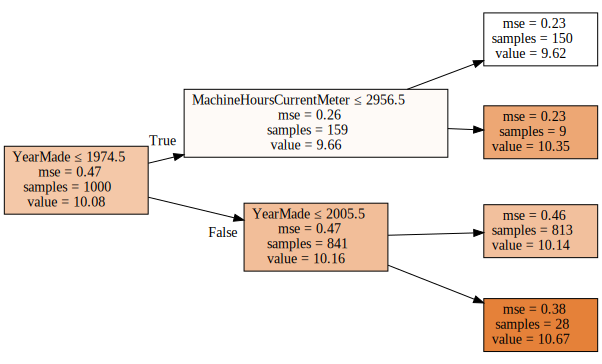

In [50]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [51]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [52]:
DecisionTree.find_varsplit = find_varsplit

In [53]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:91978.30391601802; split:1985.0; var:YearMade

In [54]:
tree.lhs

n: 301; val:9.867803605760528; score:26455.707322289985; split:1000.0; var:YearMade

In [55]:
tree.rhs

n: 699; val:10.16996457255912; score:65522.59659372821; split:2004.0; var:YearMade

In [56]:
tree.lhs.lhs

n: 113; val:9.683827269146073; score:9538.831414577206; split:2273.0; var:MachineHoursCurrentMeter

In [57]:
tree.lhs.rhs

n: 188; val:9.978385127236239; score:16916.875907712794; split:0.0; var:MachineHoursCurrentMeter

## Predictions

In [98]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [109]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

CPU times: user 539 ms, sys: 16.1 ms, total: 555 ms
Wall time: 553 ms


In [110]:
len(y_samp)

1000

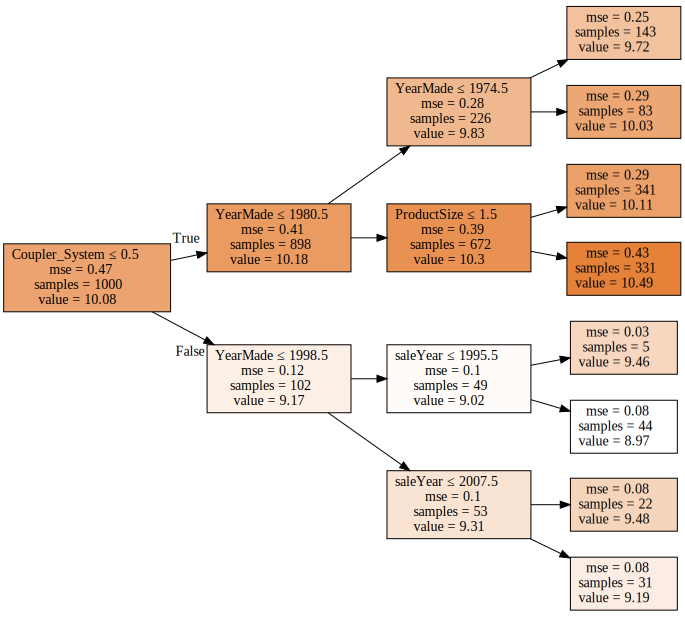

In [113]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=20)

In [114]:
metrics.r2_score(preds, y_valid)

-0.36210295459613473

In [61]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

if something:
    x= do1()
else:
    x= do2()

x = do1() if something else do2()

x = something ? do1() : do2()

In [118]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

In [119]:
%time preds = tree.predict(X_valid[cols].values)

CPU times: user 87.4 ms, sys: 60 µs, total: 87.4 ms
Wall time: 86.4 ms


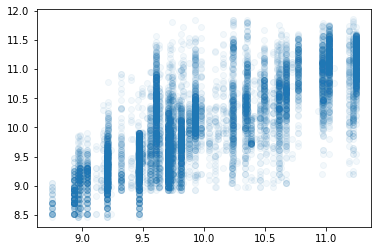

In [120]:
plt.scatter(preds, y_valid, alpha=0.05)

Predictions of our tree

In [121]:
metrics.r2_score(preds, y_valid)

0.4840854669925271

CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 21.9 ms


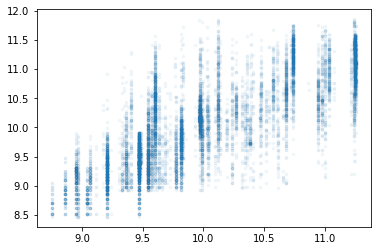

In [122]:
m = RandomForestRegressor(n_estimators=5, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05,  s=6)

Predictions of sklearn RandomForestRegressor compare with value above.

In [123]:
metrics.r2_score(preds, y_valid)

0.4754105310069473

# Putting it together

In [70]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [71]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [86]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

In [87]:
preds = ens.predict(X_valid[cols].values)

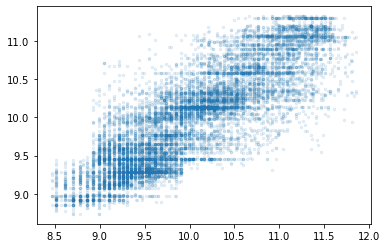

In [88]:
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [89]:
len(preds)

12000

In [82]:
metrics.r2_score(y_valid, preds)

0.7407868914873381

In [ ]:
%load_ext Cython

In [ ]:
def fib1(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%%cython
def fib2(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%%cython
def fib3(int n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = t + b

In [ ]:
%timeit fib1(50)

In [ ]:
%timeit fib2(50)

In [ ]:
%timeit fib3(50)